In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
import IPython.display as display
mpl.rcParams['figure.figsize']=(12,12)
mpl.rcParams['axes.grid']=False

In [ ]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [ ]:
upload_files()

Saving style_image.jpg to style_image.jpg


['style_image.jpg']

In [ ]:
upload_files()

Saving content_image.jpg to content_image.jpg


['content_image.jpg']

In [ ]:
def tensor_to_image(tensor):
    tensor=tensor*255;
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(img,title=None):
    if len(img.shape)>3:
        img=tf.squeeze(img,axis=0)
    plt.imshow(img)
    if title:
        plt.title(title)

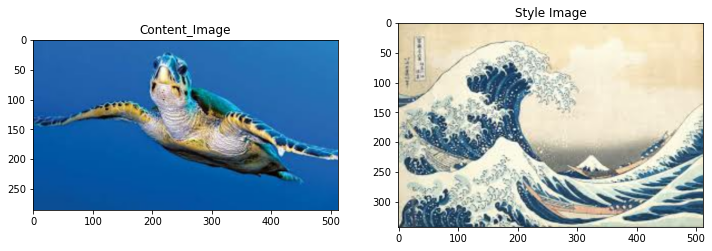

In [ ]:
content_image=load_img('content_image.jpg')
style_image=load_img('style_image.jpg')
plt.subplot(1,2,1)
imshow(content_image,'Content_Image')
plt.subplot(1,2,2)
imshow(style_image,'Style Image')

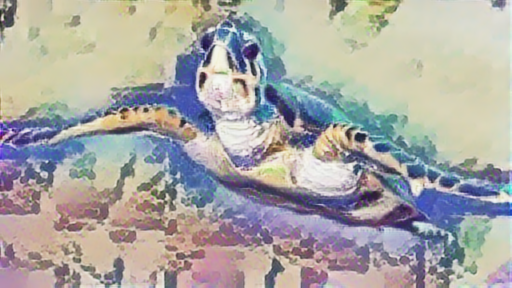

In [ ]:
import tensorflow_hub as hub
hub_module=hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image=hub_module(tf.constant(content_image),tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
x=tf.keras.applications.vgg19.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224))
vgg=tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 10s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top5=tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name,prob) for (number,class_name,prob) in predicted_top5]

40960/35363 [==================================] - 0s 0us/step


[('loggerhead', 0.73019725),
 ('leatherback_turtle', 0.15324461),
 ('terrapin', 0.029485688),
 ('coral_reef', 0.013623444),
 ('starfish', 0.013589019)]

In [ ]:
vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers=['block5_conv2']
style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
  vgg.trainable=False
  outputs=[vgg.get_layer(name).output for name in layer_names]
  model=tf.keras.Model([vgg.input],outputs)
  return model

In [ ]:
style_extractor=vgg_layers(style_layers)
style_outputs=style_extractor(style_image*255)
for name,output in zip(style_layers,style_outputs):
  print(name)
  print(" shape ",output.numpy().shape)
  print(" min ",output.numpy().min())
  print(" max ",output.numpy().max())
  print(" mean ",output.numpy().mean())


block1_conv1
 shape  (1, 343, 512, 64)
 min  0.0
 max  837.4508
 mean  34.027878
block2_conv1
 shape  (1, 171, 256, 128)
 min  0.0
 max  3070.2747
 mean  194.33852
block3_conv1
 shape  (1, 85, 128, 256)
 min  0.0
 max  9024.103
 mean  166.08871
block4_conv1
 shape  (1, 42, 64, 512)
 min  0.0
 max  14486.772
 mean  616.7766
block5_conv1
 shape  (1, 21, 32, 512)
 min  0.0
 max  2198.2585
 mean  44.04023


In [ ]:
def gram_matrix(input_tensor):
  result=tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  input_shape=tf.shape(input_tensor)
  num_locations=tf.cast(input_shape[1]*input_shape[2],tf.float32)
  return result/num_locations

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0084682815
    max:  51062.816
    mean:  1334.3657

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  261879.33
    mean:  16859.293

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  339341.66
    mean:  13163.238

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6840373.0
    mean:  177664.31

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  154224.94
    mean:  1504.4058

Contents:
   block5_conv2
    shape:  (1, 17, 32, 512)
    min:  0.0
    max:  1214.019
    mean:  13.080544


In [ ]:
content_targets=extractor(content_image)['content']
style_targets=extractor(style_image)['style']
image=tf.Variable(content_image)


In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

In [ ]:
opt=tf.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1);
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

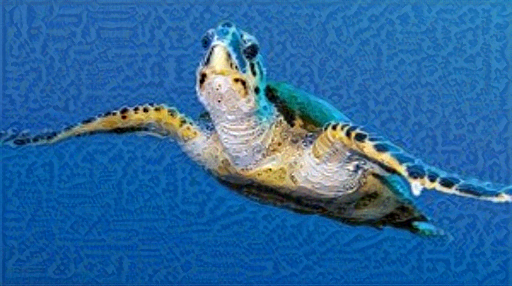

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

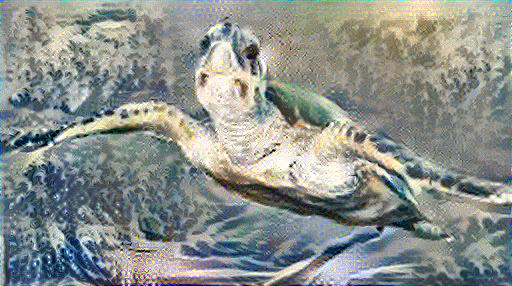

Train step: 1000
Total time: 4068.1


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))